# Mini-Project 1
**Author**: Farkhad Kuanyshkereyev<br>
**Course**: Data Science<br>
**Professor**: Sepinoud Azimi Rashti

## **Step 1 & 2 - Webscraping & Data Processing**

In [1]:
# Installing necessary packages

!pip install contractions

     |████████████████████████████████| 284 kB 8.0 MB/s 
     |████████████████████████████████| 321 kB 49.7 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85443 sha256=0c139e54edf67f40f0e4de248cdd186adf1e30402a5a96c4d915192b4adadeaa
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [2]:
# Importing necessary libraries

from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

import contractions
import datetime
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import regex as re
import requests
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')

# Links to a list of news articles of CNN in December 2019 and December 2020

news_link_2019 = 'https://edition.cnn.com/article/sitemap-2019-12.html'
news_link_2020 = 'https://edition.cnn.com/article/sitemap-2020-12.html'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Helper functions

def get_date(text):
    date = text.split('-')
    date = [int(x) for x in date]
    date = datetime.date(date[0], date[1], date[2])
    return date

def remove_redundant_words(text):
    text = text.replace('By ', '')
    text = text.replace('by ', '')
    text = text.replace('Analysis ', '')
    text = text.replace(', CNN', '')
    text = text.replace(', for CNN', '')
    text = text.replace(' CNN', '')
    text = text.replace('Video produced ', '')
    return text

def reverse_dict(info_dict):
    info_dict['title'] = info_dict['title'][::-1]
    info_dict['date'] = info_dict['date'][::-1]
    info_dict['link'] = info_dict['link'][::-1]
    return info_dict

def get_authors(info_dict):
    for i in range(len(info_dict['link'])):
        link = info_dict['link'][i]
        text = requests.get(link).text
        soup = BeautifulSoup(text, 'lxml')
        author_line = soup.find_all('span', class_='metadata__byline__author')

    if len(author_line) == 0:
        author = None
    else:
        author = author_line[0].text
        author = remove_redundant_words(author)

    info_dict['author'][i] = author
    return info_dict

In [4]:
# Function for getting title, author, date, and link from web-pages

def get_info(link):
    text = requests.get(link).text
    soup = BeautifulSoup(text, 'lxml')
    sitemap_entry_class = soup.find_all('div', class_='sitemap-entry')[1]
    span_of_news = sitemap_entry_class.find_all('span')
    info = {
      'title': [],
      'author': [],
      'date': [],
      'link': []
    }

    for i in range(0, len(span_of_news), 2):
        date = get_date(span_of_news[i].text)

    if date > datetime.date(date.year, 12, 14):
        continue

    link = span_of_news[i+1].a['href']
    title = span_of_news[i+1].text

    info['title'].append(title)
    info['author'].append(None)
    info['date'].append(date)
    info['link'].append(link)

    info = reverse_dict(info)
    info = get_authors(info)

    return info

In [5]:
# Takes approximately 35-50 seconds

news_info_2019 = get_info(news_link_2019)
news_info_2020 = get_info(news_link_2020)

In [6]:
# Concatenating news from December 2019 and December 2020 and showing the result

df_news_2019 = pd.DataFrame(news_info_2019)
df_news_2020 = pd.DataFrame(news_info_2020)

df_news = pd.concat([df_news_2019, df_news_2020])
df_news['id'] = range(1, len(df_news)+1)
df_news = df_news[['id', 'title', 'author', 'date', 'link']]

In [7]:
df_news

,id,title,author,date,link
0,1,Irish 'ISIS bride' Lisa Smith in custody in Du...,"Schams Elwazer, Peter Taggart and Tara John",2019-12-01,https://edition.cnn.com/2019/12/01/europe/isis...
1,2,Lewis Hamilton wins Abu Dhabi GP as Formula 1 ...,Ben Church,2019-12-01,https://edition.cnn.com/2019/12/01/motorsport/...
2,3,Acts of heroism emerge after London terror attack,"Tara John, Vasco Cotovio and Lauren Kent",2019-12-01,https://edition.cnn.com/2019/11/30/uk/london-b...
3,4,Suspect in deadly stabbing near London Bridge ...,"Rob Picheta, Nicole Chavez and Nick Paton Walsh",2019-12-01,https://edition.cnn.com/2019/11/29/uk/london-b...
4,5,This is what we know about London Bridge stabb...,"Sebastian Shukla, Nicole Chavez and Hollie Sil...",2019-12-01,https://edition.cnn.com/2019/11/29/europe/lond...
...,...,...,...,...,...
105,247,Germany to go into national lockdown over Chri...,Claudia Otto,2020-12-14,https://edition.cnn.com/2020/12/13/europe/germ...
106,248,Asked how clean he thinks the Olympics will be...,Don Riddell and Ben Church,2020-12-14,https://edition.cnn.com/2020/12/12/sport/micha...
107,249,"Gérard Houllier, former Liverpool and France m...",Ben Morse,2020-12-14,https://edition.cnn.com/2020/12/14/football/gr...
108,250,Visit from Santa may have infected 75 with cor...,Mick Krever and Jack Guy,2020-12-14,https://edition.cnn.com/2020/12/14/europe/belg...


## **Step 3 - Exploratory Data Analysis (EDA)**

In [8]:
# Creating year and day columns in the dataframe

df_news['year'] = pd.DatetimeIndex(df_news['date']).year
df_news['day'] = pd.DatetimeIndex(df_news['date']).day

In [9]:
# Showing the result of data processing

df_news.head()

,id,title,author,date,link,year,day
0,1,Irish 'ISIS bride' Lisa Smith in custody in Du...,"Schams Elwazer, Peter Taggart and Tara John",2019-12-01,https://edition.cnn.com/2019/12/01/europe/isis...,2019,1
1,2,Lewis Hamilton wins Abu Dhabi GP as Formula 1 ...,Ben Church,2019-12-01,https://edition.cnn.com/2019/12/01/motorsport/...,2019,1
2,3,Acts of heroism emerge after London terror attack,"Tara John, Vasco Cotovio and Lauren Kent",2019-12-01,https://edition.cnn.com/2019/11/30/uk/london-b...,2019,1
3,4,Suspect in deadly stabbing near London Bridge ...,"Rob Picheta, Nicole Chavez and Nick Paton Walsh",2019-12-01,https://edition.cnn.com/2019/11/29/uk/london-b...,2019,1
4,5,This is what we know about London Bridge stabb...,"Sebastian Shukla, Nicole Chavez and Hollie Sil...",2019-12-01,https://edition.cnn.com/2019/11/29/europe/lond...,2019,1


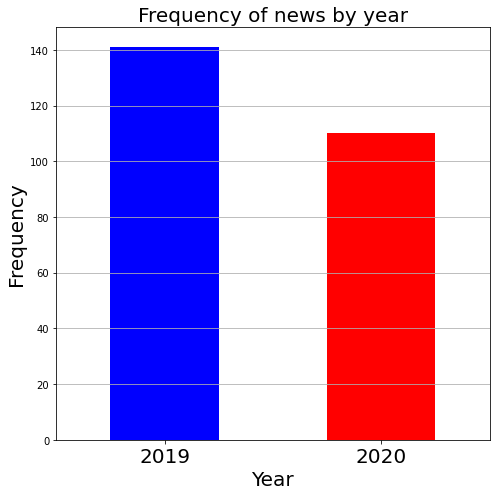

In [10]:
# Plotting the frequency of news by year

fontsize = 20

plt.figure(figsize=(7, 7))

df_news['year'].value_counts().plot(kind='bar', color=['blue', 'red'])

plt.title('Frequency of news by year', fontsize=fontsize)
plt.xlabel('Year', fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)
plt.grid(axis='y')
plt.xticks(rotation=0, fontsize=fontsize)
plt.tight_layout()
plt.show();

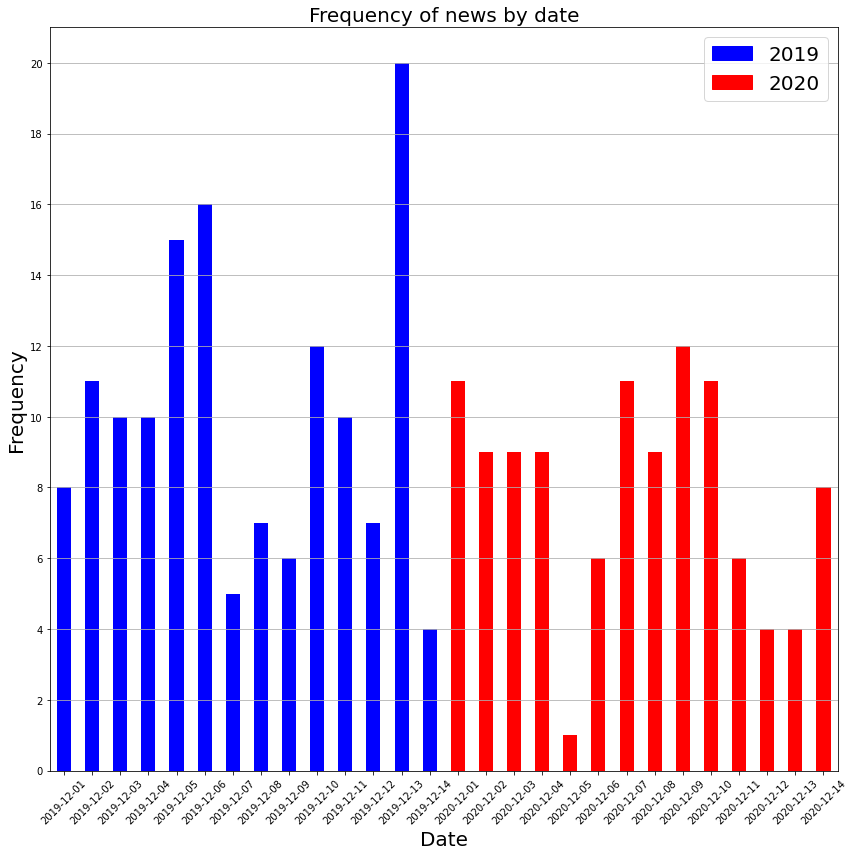

In [20]:
# Plotting the frequency of news by date

plt.figure(figsize=(12, 12))
color = ['blue'] * 14 + ['red'] * 14

df_news['date'].value_counts().sort_index().plot(kind='bar', color=color)

plt.title('Frequency of news by date', fontsize=fontsize)
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.yticks(range(0, 22, 2))

patch_2019 = mpatches.Patch(color='blue', label='2019')
patch_2020 = mpatches.Patch(color='red', label='2020')

plt.legend(handles=[patch_2019, patch_2020], fontsize=20)
plt.tight_layout()
plt.show();

In [12]:
# Preprocessing titles and applying tokenization on them

stop_words = set(stopwords.words('english'))

def get_tokenized_title(df):
    tokenized_title = df['title'].apply(lambda x: [contractions.fix(word) for word in x.split()])
    tokenized_title = pd.Series([' '.join(x) for x in tokenized_title])
    tokenized_title = tokenized_title.str.lower()
    tokenized_title = tokenized_title.apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))
    tokenized_title = tokenized_title.apply(word_tokenize)
    tokenized_title = tokenized_title.apply(lambda x: [word for word in x if word not in stop_words])
    tokenized_title = [' '.join(x) for x in tokenized_title]
    return tokenized_title

df_news['tokenized_title'] = get_tokenized_title(df_news)

In [13]:
# Splitting the dataframe by year

df_news_2019 = df_news[df_news['year'] == 2019]
df_news_2020 = df_news[df_news['year'] == 2020]

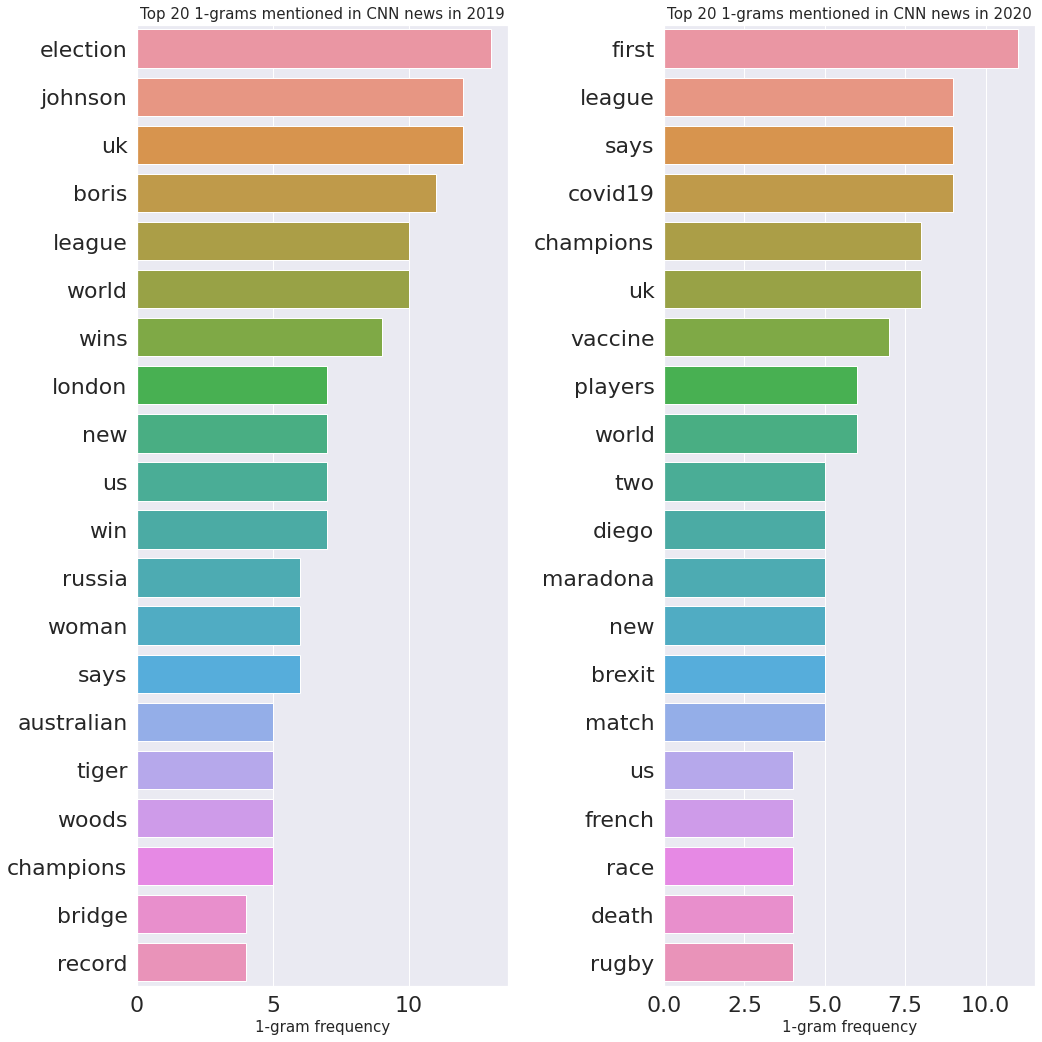

In [38]:
# Plotting top unigrams, bigrams, and trigrams from titles of news for different time periods

def get_corpus(text):
    text = text.str.split()
    text = text.values.tolist()
    corpus = [word for i in text for word in i]
    return corpus

def plot_comparison_top_ngrams_barcharts(text1, text2, top_size=20, n=2):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(15)
    fig.set_figheight(15)

    corpus1 = get_corpus(text1)
    corpus2 = get_corpus(text2)

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:top_size]

    top_n_bigrams1 = _get_top_ngram(text1, n)[:top_size]
    top_n_bigrams2 = _get_top_ngram(text2, n)[:top_size]
    x1, y1 = map(list, zip(*top_n_bigrams1))
    x2, y2 = map(list, zip(*top_n_bigrams2))

    ax[0].set_xlabel(f'{n}-gram frequency', fontsize=15)
    ax[0].set_title(f'Top {top_size} {n}-grams mentioned in CNN news in 2019', fontsize=15)
    ax[1].set_xlabel(f'{n}-gram frequency', fontsize=15)
    ax[1].set_title(f'Top {top_size} {n}-grams mentioned in CNN news in 2020', fontsize=15)
    sns.barplot(x=y1, y=x1, ax=ax[0])
    sns.barplot(x=y2, y=x2, ax=ax[1])
    fig.tight_layout()

plot_comparison_top_ngrams_barcharts(
    text1=df_news_2019['tokenized_title'], 
    text2=df_news_2020['tokenized_title'],
    top_size=20,
    n=1    
)

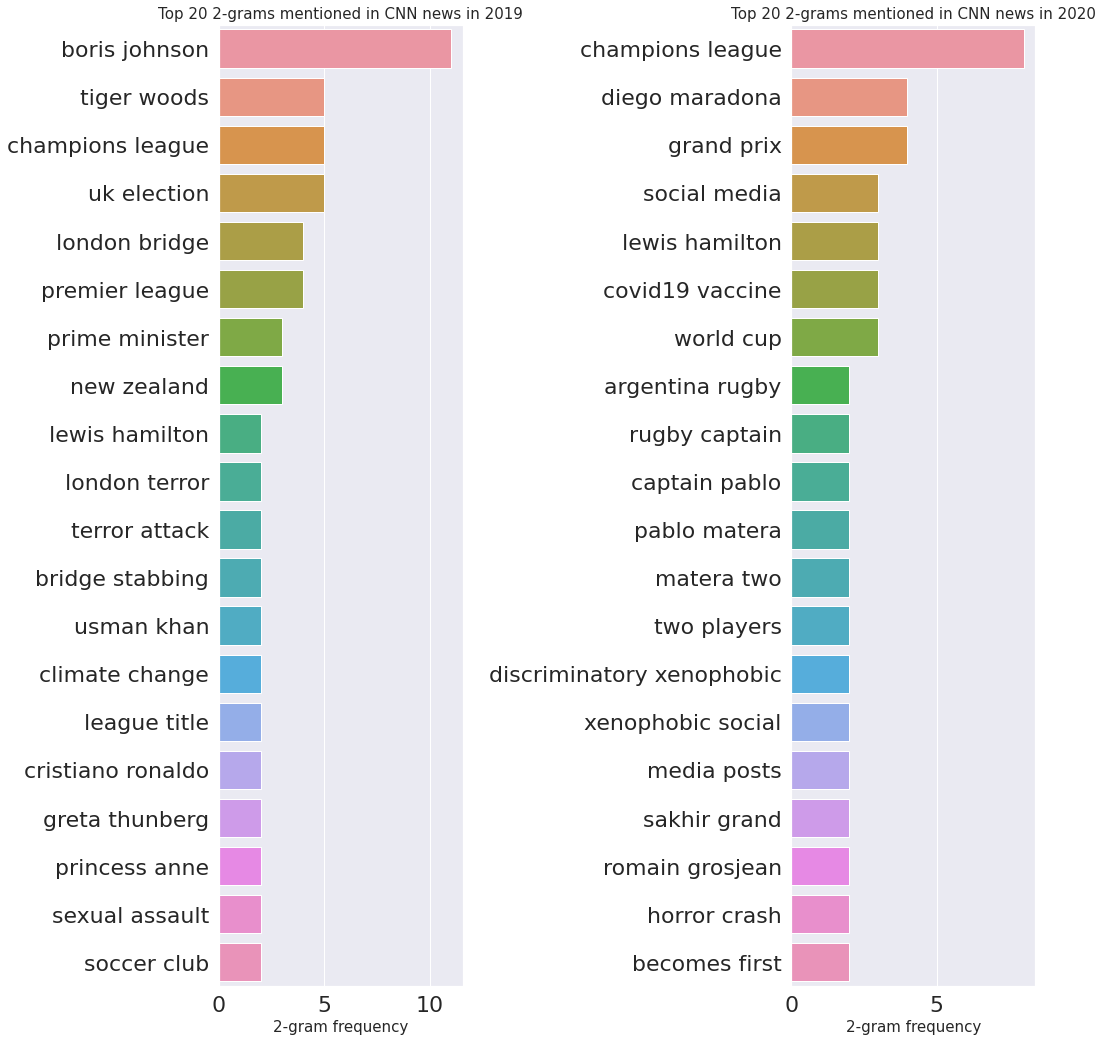

In [39]:
plot_comparison_top_ngrams_barcharts(
    text1=df_news_2019['tokenized_title'], 
    text2=df_news_2020['tokenized_title'],
    top_size=20,
    n=2    
)

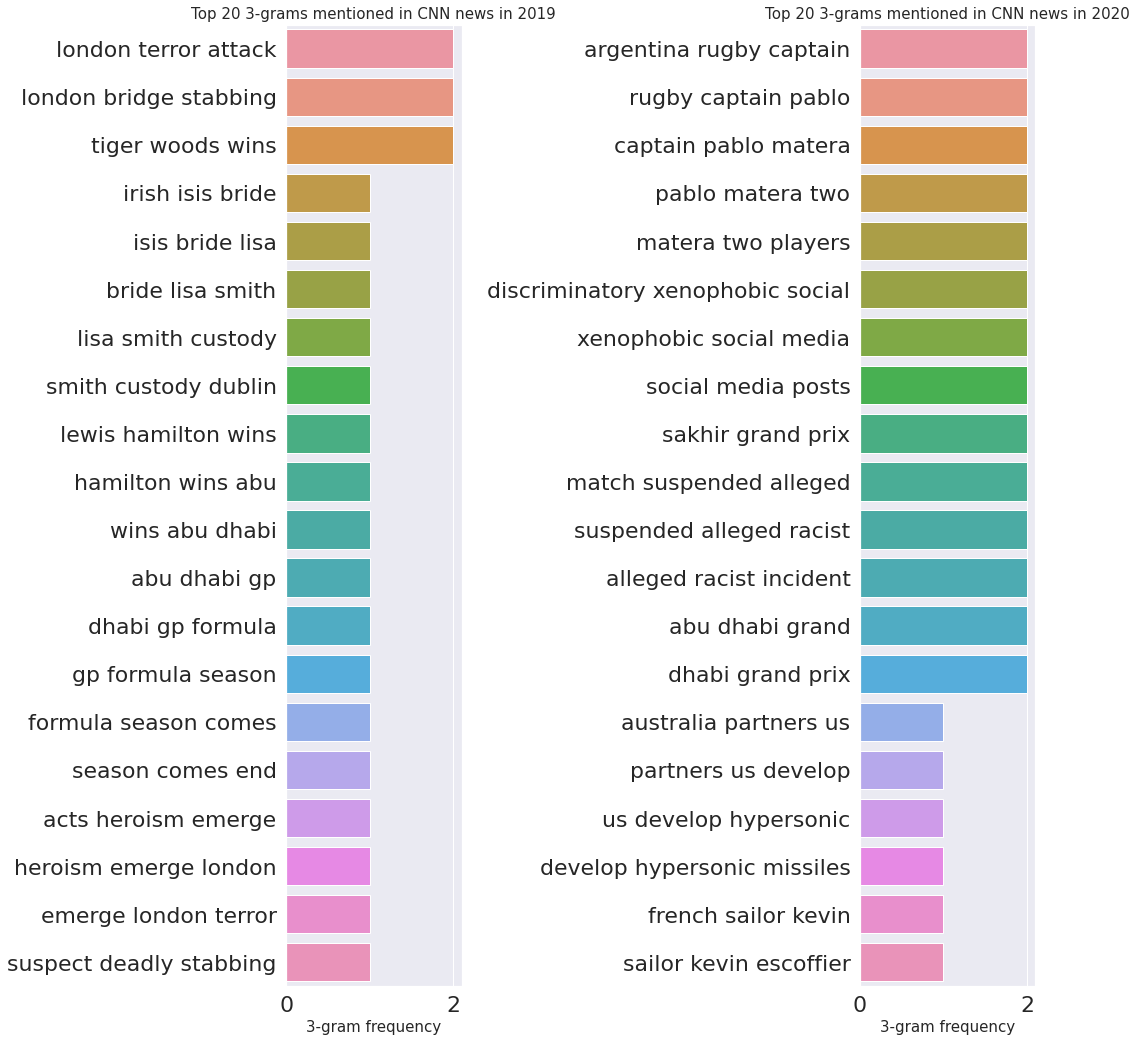

In [40]:
plot_comparison_top_ngrams_barcharts(
    text1=df_news_2019['tokenized_title'], 
    text2=df_news_2020['tokenized_title'],
    top_size=20,
    n=3    
)

## **Step 4 - Comparison Analysis Study**

In [17]:
# Categorizing articles by title into manually defined topics by finding the highest occuring keywords

categories = {
    'topic': ['Health', 'Sport', 'Politics', 'Emergency'],
    'keywords': [
                 ['covid19', 'vaccine', 'pandemic', 'disease', 'health'], 
                 ['premier', 'league', 'champions', 'tiger', 'woods', 'wins', 'soccer', 'formula', 
                  'lewis', 'cup', 'world', 'captain', 'pablo', 'matera', 'sakhir', 'hamilton', 'race', 
                  'christiano', 'ronaldo', 'grand', 'prix', 'rugby', 'diego', 'maradona', 'players', 'record'], 
                 ['election', 'uk', 'us', 'brexit', 'boris', 'johnson', 'prime', 'minister'],
                 ['london', 'bridge', 'terror', 'attack', 'stabbing', 'usman', 'khan', 'heroism']],
    'count_2019': [0, 0, 0, 0],
    'count_2020': [0, 0, 0, 0]
}

def count_topic_occurrences(df, year=2019, num_topics=4):
    topics = []

    for title in df['tokenized_title']:
        counts = [0] * num_topics

    for i in range(num_topics):
        keywords = categories['keywords'][i]

        for j in range(len(keywords)):
            counts[i] += title.count(keywords[j])

    max_index = np.argmax(counts)
    categories[f'count_{year}'][max_index] += 1
    topics.append(categories['topic'][max_index])

    return topics

df_news_2019['topic'] = count_topic_occurrences(df_news_2019, 2019)
df_news_2020['topic'] = count_topic_occurrences(df_news_2020, 2020)
df_news = pd.concat([df_news_2019, df_news_2020])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


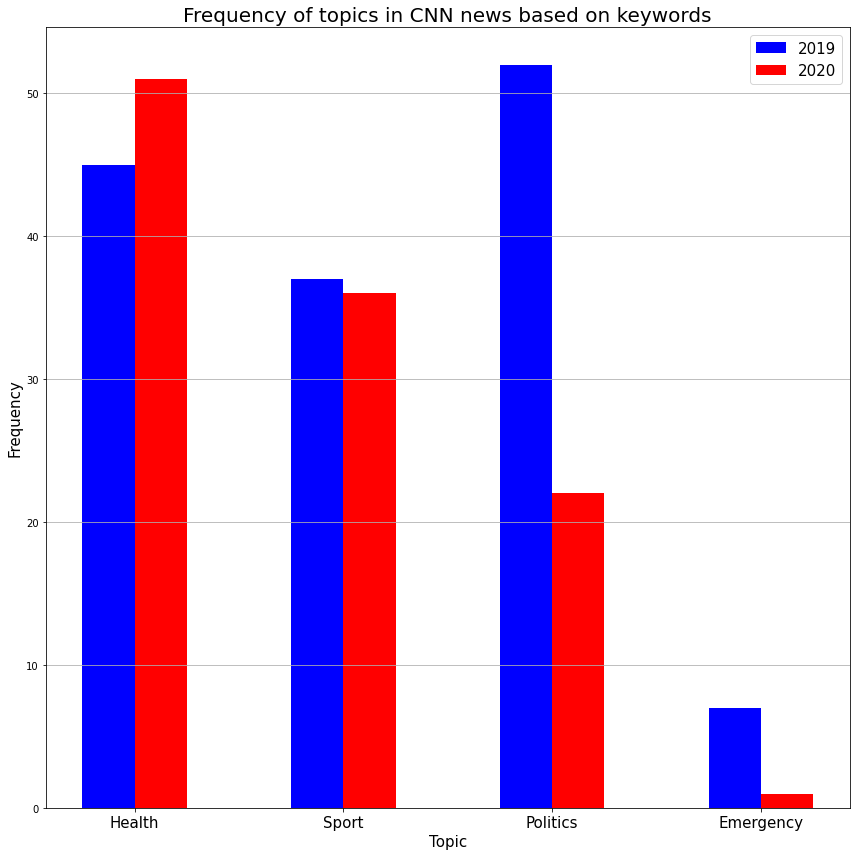

In [18]:
# Plotting the frequency of topics in CNN news based on manually defined keywords

plt.figure(figsize=(12, 12))

plt.bar(np.arange(4), categories['count_2019'], color='blue', width=0.25)
plt.bar(np.arange(4) + 0.25, categories['count_2020'], color='red', width=0.25)

plt.title('Frequency of topics in CNN news based on keywords', fontsize=20)
plt.xlabel('Topic', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.legend(['2019', '2020'], fontsize=15)
plt.xticks(np.arange(4) + 0.25 / 2, categories['topic'], fontsize=15)

plt.grid(axis='y')
plt.tight_layout()
plt.show();

**NOTE:** All of the interpretations and thoughts are stated and explained in the report.

## **Step 5 - Interaction with the User**

In [19]:
# Creating a user interaction for getting a link for the desired article

def print_topics():
    print('List of possible topics:\n')
    print('- Health')
    print('- Sport')
    print('- Politics')
    print('- Emergency\n')

def print_articles(df):
    topic_name = df['title'].values[0]
    print(f'You have chosen the topic \'{topic_name}\'. Here is the list of article IDs and titles:\n')
    print('ID     Title')

    for idx, row in df.iterrows():
        print('{0: <6} {1:}'.format(row['id'], row['title']))

def print_result(row):
    article_id = row['id'].values[0]
    title = row['title'].values[0]
    link = row['link'].values[0]

    print(f'\nID: {article_id}')
    print(f'Title: {title}')
    print(f'Link: {link}')

def get_topic_name():
    topic_name = None

    while not topic_name:
        topic_name = input('Please, input the topic name: ')
        topic_name = topic_name.lower().capitalize()

        if topic_name not in categories['topic']:
            print(f'Sorry! There is no topic called \'{topic_name}\'.\n')
            topic_name = None

    return topic_name

def get_article_id(df):
    article_id = None

    while not article_id:
        article_id = input('\nPlease, input the article ID: ')

        try:
            article_id = int(article_id)
        except ValueError:
            pass

        if article_id not in df['id'].values:
            print(f'Sorry! There is no article with ID {article_id}.\n')
            article_id = None

    return article_id

def get_article():
    print_topics()
    topic_name = get_topic_name()

    df = df_news[df_news['topic'] == topic_name]

    print_articles(df)
    article_id = get_article_id(df)

    row = df[df['id'] == article_id]

    print_result(row)

get_article()

List of possible topics:

- Health
- Sport
- Politics
- Emergency

Please, input the topic name: emergency
You have chosen the topic 'Acts of heroism emerge after London terror attack'. Here is the list of article IDs and titles:

ID     Title
3      Acts of heroism emerge after London terror attack
4      Suspect in deadly stabbing near London Bridge identified
5      This is what we know about London Bridge stabbing suspect Usman Khan
6      Hundreds of former jihadis are set to be freed from jail. London terror attack shows the risks
15     Both London Bridge stabbing victims named as University of Cambridge graduates
26     Usman Khan's longtime lawyer 'completely shocked' by London Bridge attack
33     London Mayor says Trump appears to care only about white America
149    Boy thrown from London's Tate Modern gallery is starting to walk, family says

Please, input the article ID: 4

ID: 4
Title: Suspect in deadly stabbing near London Bridge identified
Link: https://edition.cnn.com